<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/data_impute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd '/gdrive/My Drive/tensor-flow-state/tensor-flow-state'

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
sensor_list = ['RWS01_MONIBAS_0021hrl0414ra', 'RWS01_MONIBAS_0021hrl0403ra', 'RWS01_MONIBAS_0021hrl0409ra', 'RWS01_MONIBAS_0021hrl0420ra', 'RWS01_MONIBAS_0021hrl0426ra']

In [0]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

In [0]:
def join_sensors(sensor_list):
    combined_df = pd.DataFrame({'timestamp': pd.date_range(start = '2011-01-01',end = '2019-12-31', freq = 'T')})
    combined_df.set_index('timestamp', drop = True, inplace = True)
    for i, sensor in enumerate(sensor_list):
        # only add speed limit on the final sensor
        if i == len(sensor_list) - 1:
            df = pd.read_csv('data/' + sensor + ".csv", index_col = 0, parse_dates = True)
            combined_df = combined_df.join(df, how = 'outer', rsuffix = '_' + sensor)
        else:
            df = pd.read_csv('data/' + sensor + ".csv", usecols = [0, 1, 2], index_col = 0, parse_dates = True)
            combined_df = combined_df.join(df, how = 'outer', rsuffix = '_' + sensor)
    combined_df.dropna(how = 'all', axis = 0, inplace = True) # this works in all cases because speed_limit is never NA on a sensor df
    return combined_df
        
combined_df = join_sensors(sensor_list)
combined_df.to_csv('data/combined_df.csv')

In [0]:
df = pd.read_csv('data/combined_df.csv', index_col = 0, parse_dates = True)

In [46]:
records = len(df)
null_records = len(df.loc[df.isnull().any(axis=1)])
null_ratio = len(df.loc[df.isnull().any(axis=1)]) / len(df)

print(f"\
Number of records:      {records:,}\n\
Number of null records: {null_records:,}\n\
Null ratio:             {null_ratio:.3f}\
")

Number of records:      4,727,520
Number of null records: 448,433
Null ratio:             0.095


In [0]:
pd.set_option('display.max_rows', 500)
df.speed[df.speed.notna()].astype(int).value_counts().head(25)

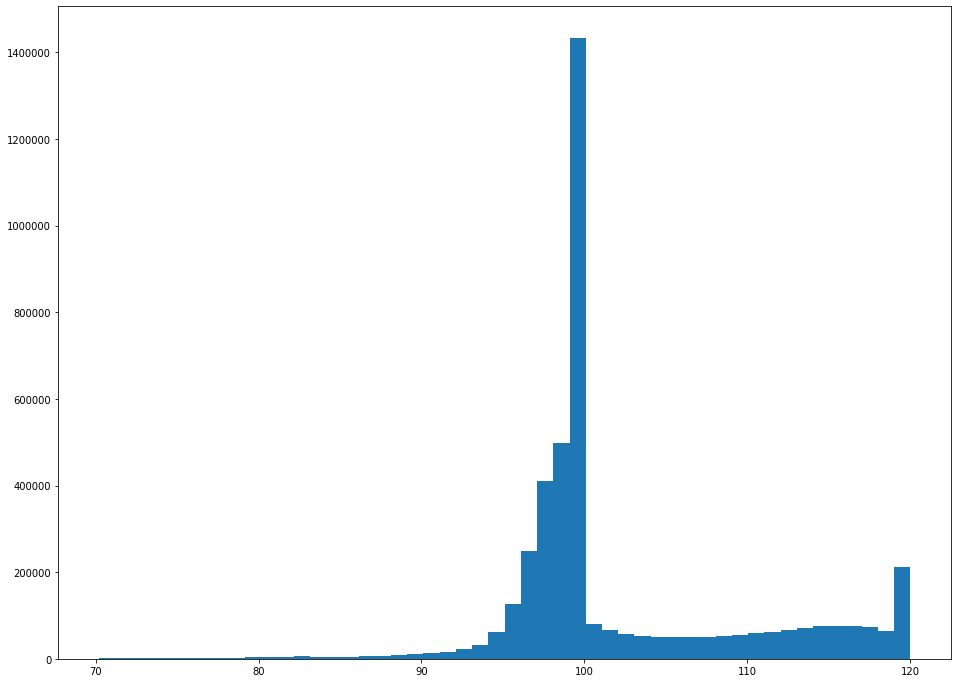

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,12))
df.speed[(df.speed.notna()) & (df.speed > 70)].hist(bins = 50, grid = False)

In [0]:
df2 = df.resample('M').agg({'speed': np.mean, 'flow': np.sum})

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


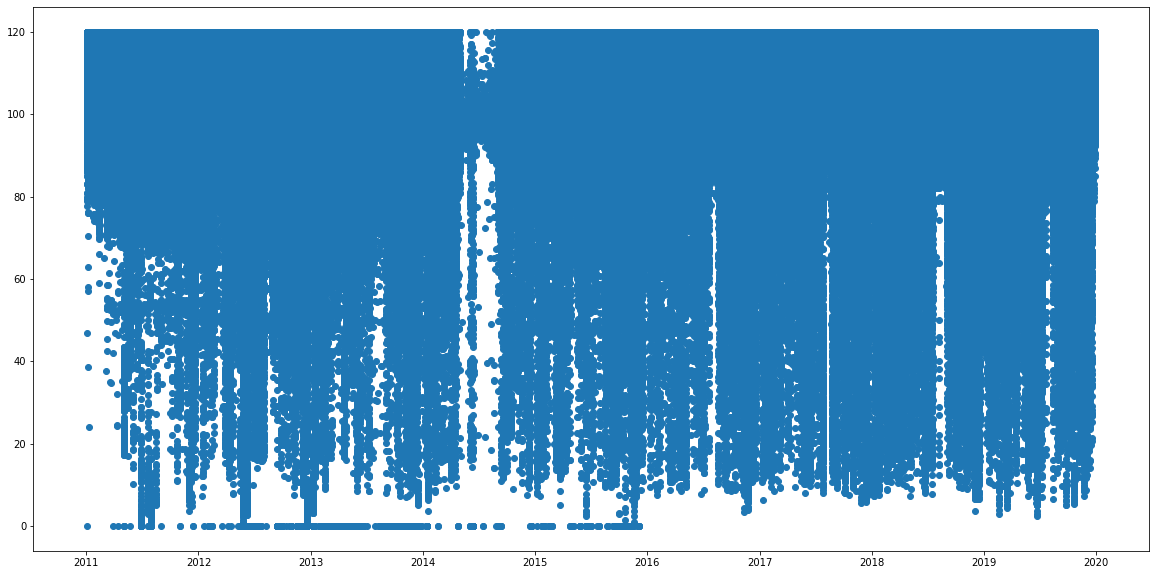

In [49]:
plt.figure(figsize=(20,10))
plt.scatter(df.index, df.speed)

In [50]:
df['null'] = np.where(df.speed.isna(), 1, np.nan)
df['timestamp'] = df.index
df.groupby(pd.Grouper(key='timestamp', freq='M'))['null'].sum()

timestamp
2011-01-31      69.00
2011-02-28     150.00
2011-03-31     812.00
2011-04-30     336.00
2011-05-31     394.00
2011-06-30     195.00
2011-07-31    1762.00
2011-08-31    6077.00
2011-09-30     212.00
2011-10-31    1937.00
2011-11-30     165.00
2011-12-31     249.00
2012-01-31    1568.00
2012-02-29     680.00
2012-03-31    2018.00
2012-04-30    2365.00
2012-05-31     121.00
2012-06-30     722.00
2012-07-31   14973.00
2012-08-31     819.00
2012-09-30     146.00
2012-10-31    9376.00
2012-11-30      15.00
2012-12-31      44.00
2013-01-31    2973.00
2013-02-28    1267.00
2013-03-31    1873.00
2013-04-30    1036.00
2013-05-31    2219.00
2013-06-30    2184.00
2013-07-31    1265.00
2013-08-31    1378.00
2013-09-30    2254.00
2013-10-31    3050.00
2013-11-30    4116.00
2013-12-31    3663.00
2014-01-31    4774.00
2014-02-28    3897.00
2014-03-31    2245.00
2014-04-30    1537.00
2014-05-31   44282.00
2014-06-30   39657.00
2014-07-31   44357.00
2014-08-31   43324.00
2014-09-30     394.00
